In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline
import sys
#!{sys.executable} -m pip install -U imbalanced-learn
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

### Leitura dos dados

In [2]:
dados = pd.read_csv("train.csv")
#dados_teste = pd.read_csv("eleicoes_2014.csv")
#dados_teste.columns = ["ano","sequencial_candidato","nome","uf","partido","quantidade_doacoes","quantidade_doadores","total_receita","media_receita","recursos_de_outros_candidatos/comites","recursos_de_pessoas_fisicas","recursos_de_pessoas_juridicas","recursos_proprios","quantidade_despesas","quantidade_fornecedores","total_despesa","media_despesa","cargo","sexo","grau","estado_civil","ocupacao","votos"]

### Há desbalanceamento das classes (isto é, uma classe tem muito mais instâncias que outra)? Em que proporção? Quais efeitos colaterais o desbalanceamento de classes pode causar no classificador? Como você poderia tratar isso? (1 pt.)

In [3]:
dados.situacao.value_counts()

nao_eleito    6596
eleito        1026
Name: situacao, dtype: int64

* Há sim desbalanceamento entre as classes.
* nao_eleito = 86,5% e eleito = 13,5%.
* Pode criar um viés no classificador favorecendo a classe com maior número de entradas.
* Usar alguma combinação de oversampling com undersampling para balancear as classes.

In [4]:
numeric_feats = dados.dtypes[dados.dtypes != "object"].index
#dados = dados.fillna(dados.mean())
dados[numeric_feats] = dados.groupby(['partido', 'uf', 'ano'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido', 'uf'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dados[numeric_feats] = dados.groupby(['partido'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

skewed_feats = dados[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
dados[skewed_feats] = np.log1p(dados[skewed_feats])

dados = dados.fillna(dados.median())
dados = dados.drop(columns = ['nome', 'sequencial_candidato'])
dados = pd.get_dummies(dados, columns = ['uf', 'partido', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao'])
dados["situacao"] = dados["situacao"].astype('category')
dados["situacao"] = dados["situacao"].cat.codes
#y = dados.situacao
#treino = dados.drop(columns = ['situacao'])

In [5]:
#from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(dados.drop(columns = ['situacao']), dados.situacao)

x = pd.DataFrame(data=X_res[0:,0:])
x.columns = dados.drop(columns = ['situacao']).columns
x['situacao'] = y_res
x = x.fillna(x.median())

### Separação treino e teste

In [6]:
treino =  dados[dados.ano == 2006]
y_treino = treino.situacao
treino = treino.drop(columns = ['situacao'])

teste = dados[dados.ano == 2010]
y_teste = teste.situacao
teste = teste.drop(columns = ['situacao'])

treino_balanceado = x[x.ano == 2006]
y_treino_balanceado = treino_balanceado.situacao
treino_balanceado = treino_balanceado.drop(columns = ['situacao'])

teste_balanceado = x[x.ano == 2010]
y_teste_balanceado = teste_balanceado.situacao
teste_balanceado = teste_balanceado.drop(columns = ['situacao'])

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

### Função de cálculo de rmse com cross validation

In [8]:
def cv(model):
    f1= cross_val_score(model, treino, y_treino, scoring='f1', cv = 10)
    return(f1)


In [9]:
def cv_balanceado(model):
    f1= cross_val_score(model, treino_balanceado, y_treino_balanceado, scoring='f1', cv = 10)
    return(f1)

### Cálculo de f1 das árvores para diferentes máximos de tamanho para os dados desbalanceados

In [10]:
alphas = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75]
f1_arvores = [cv(tree.DecisionTreeClassifier(max_depth=alpha)).mean() 
            for alpha in alphas]

### Plot do F1 para cada alpha

Text(0,0.5,'f1')

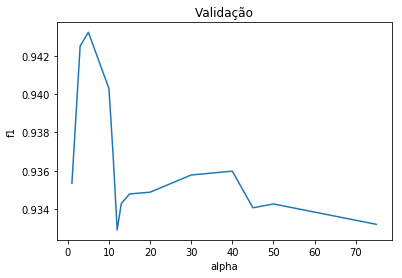

In [11]:
f1_arvores = pd.Series(f1_arvores, index = alphas)
f1_arvores.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("f1")

### Melhor modelo

In [12]:
f1_arvores.idxmax()
arvore = tree.DecisionTreeClassifier(max_depth=f1_arvores.idxmax()).fit(treino, y_treino)
arvore.score(teste, y_teste)

0.8997772828507795

### Cálculo de f1 das árvores para diferentes máximos de tamanho para os dados balanceados

In [13]:
alphas = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75]
f1_arvores_balanceado = [cv_balanceado(tree.DecisionTreeClassifier(max_depth=alpha)).mean() 
            for alpha in alphas]

### Plot do F1 para cada alpha

Text(0,0.5,'f1')

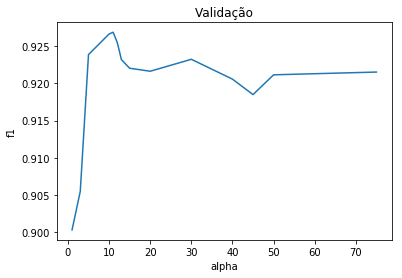

In [14]:
f1_arvores_balanceado = pd.Series(f1_arvores_balanceado, index = alphas)
f1_arvores_balanceado.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("f1")

### Melhor modelo

In [15]:
f1_arvores_balanceado.idxmax()
arvore_balanceado = tree.DecisionTreeClassifier(max_depth=f1_arvores_balanceado.idxmax()).fit(treino_balanceado, y_treino_balanceado)
arvore_balanceado.score(teste_balanceado, y_teste_balanceado)

0.9196750902527075

### Geração de modelo de regressão logistica com dados desbalanceado

In [16]:
logistic = LogisticRegression()
logistic.fit(treino, y_treino)
logistic.score(teste,y_teste)

C:\Users\Luiz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9173471912892849

### Geração de modelo de regressão logistica com dados balanceado

In [17]:
logistic = LogisticRegression()
logistic.fit(treino_balanceado, y_treino_balanceado)
logistic.score(teste_balanceado,y_teste_balanceado)

C:\Users\Luiz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9180204572803851

### Cálculo de f1 dos modelos KNN para diferentes número de vizinhos para os dados balanceados

In [18]:
alphas = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75, 100]
f1_knn = [cv_balanceado(KNeighborsClassifier(n_neighbors=alpha)).mean() 
            for alpha in alphas]

### F1 para cada alpha

Text(0,0.5,'f1')

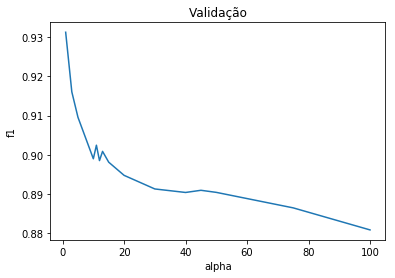

In [19]:
f1_knn = pd.Series(f1_knn, index = alphas)
f1_knn.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("f1")

### Criação do modelo com melhor alpha

In [20]:
f1_knn.idxmax()
knn = KNeighborsClassifier(n_neighbors=f1_knn.idxmax()).fit(treino_balanceado, y_treino_balanceado)
knn.score(teste_balanceado, y_teste_balanceado)

0.8564981949458483

### Cálculo de f1 dos modelos KNN para diferentes número de vizinhos para os dados desbalanceados

In [21]:
alphas = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75, 100]
f1_knn_desb = [cv(KNeighborsClassifier(n_neighbors=alpha)).mean() 
            for alpha in alphas]

### F1 para cada alpha

Text(0,0.5,'f1')

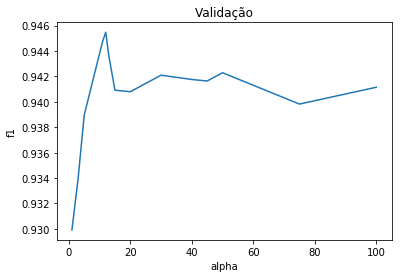

In [22]:
f1_knn_desb = pd.Series(f1_knn_desb, index = alphas)
f1_knn_desb.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("f1")

### Melhor modelo

In [23]:
f1_knn_desb.idxmax()
knn = KNeighborsClassifier(n_neighbors=f1_knn_desb.idxmax()).fit(treino, y_treino)
knn.score(teste, y_teste)

0.906953724325662

### Cálculo de f1 dos modelos Adaboost para diferentes número de vizinhos para os dados balanceados

In [24]:
alphas = [ 1, 3, 5,10,11,12,13,15, 20,30,40,45, 50, 75, 100, 200, 300, 400]
f1_ada_balanceado = [cv_balanceado(AdaBoostClassifier(n_estimators=alpha)).mean() 
            for alpha in alphas]

### F1 para cada alpha

Text(0,0.5,'f1')

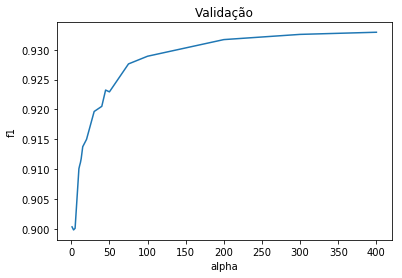

In [25]:
f1_ada_balanceado = pd.Series(f1_ada_balanceado, index = alphas)
f1_ada_balanceado.plot(title = "Validação")
plt.xlabel("alpha")
plt.ylabel("f1")

### Melhor modelo

In [26]:
f1_ada_balanceado.idxmax()
ada = AdaBoostClassifier(n_estimators=f1_ada_balanceado.idxmax()).fit(treino_balanceado, y_treino_balanceado)
ada.score(teste_balanceado, y_teste_balanceado)

0.934265944645006

In [58]:
def imprimirEstatisticas(nome, modelo):
    print(nome)
    predicao = modelo.predict(dados_teste)
    rmse = np.sqrt(mean_squared_error(y_2014, predicao))
    r_squared = modelo.score(dados_teste, y_2014)
    print("RMSE: ", rmse)
    print("R²: ", r_squared)

In [61]:
model_ridge = Ridge(alpha = cv_ridge.idxmin())
model_ridge.fit(dados, y)
imprimirEstatisticas("Ridge", model_ridge)
model_lasso = Lasso(alpha = cv_lasso.idxmin(), max_iter=10000)
model_lasso.fit(dados, y)
imprimirEstatisticas("Lasso", model_lasso)
reg = LinearRegression()
reg.fit(dados, y)
imprimirEstatisticas("Regressão Linear", reg)
neigh = KNeighborsRegressor(n_neighbors=cv_knn.idxmin())
neigh.fit(dados, y)
imprimirEstatisticas("K-nn", neigh)
forest = RandomForestRegressor(n_estimators=cv_random_forest.idxmin())
forest.fit(dados, y)
imprimirEstatisticas("Random Forest", forest)

Ridge
RMSE:  1.83947161957029
R²:  0.4820552806206254
Lasso
RMSE:  1.8392693337060046
R²:  0.48216919065129193
Regressão Linear
RMSE:  1.8531774725088563
R²:  0.47430814189088966
K-nn
RMSE:  1.8465831346197923
R²:  0.4780427242943903
Random Forest
RMSE:  1.8830857808162569
R²:  0.45720300540876757


### Conclusão
Mesmo o K-nn dando a entender que poderia prever melhor dado os resíduos o Ridge e o Lasso foram os algortimos que tiveram os melhores resultados tanto no RMSE como no R². Isso se deve ao fato que a regularização ajuda a evitar o overfit e ter resultados melhores prevendo dados nunca vistos. 

In [107]:
test = pd.read_csv("test.csv")
dadosOriginal = pd.read_csv("train.csv")

In [108]:
numeric_feats = test.dtypes[test.dtypes != "object"].index
#dados = dados.fillna(dados.mean())
test[numeric_feats] = test.groupby(['partido', 'uf', 'ano'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
test[numeric_feats] = test.groupby(['partido', 'uf'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
test[numeric_feats] = test.groupby(['partido'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

skewed_feats = test[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
test[skewed_feats] = np.log1p(test[skewed_feats])
sequencial = test.sequencial_candidato
test = test.fillna(dados.median())
test = test.drop(columns = ['nome', 'sequencial_candidato'])
#test = pd.get_dummies(test, columns = ['uf', 'partido', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao'])

numeric_feats = dadosOriginal.dtypes[dadosOriginal.dtypes != "object"].index
#dados = dados.fillna(dados.mean())
dadosOriginal[numeric_feats] = dadosOriginal.groupby(['partido', 'uf', 'ano'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dadosOriginal[numeric_feats] = dadosOriginal.groupby(['partido', 'uf'])[numeric_feats].transform(lambda x: x.fillna(x.median()))
dadosOriginal[numeric_feats] = dadosOriginal.groupby(['partido'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

skewed_feats = dadosOriginal[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
dadosOriginal[skewed_feats] = np.log1p(dadosOriginal[skewed_feats])

dadosOriginal = dadosOriginal.fillna(dadosOriginal.median())
dadosOriginal = dadosOriginal.drop(columns = ['nome', 'sequencial_candidato', 'situacao'])

In [109]:
all_data = pd.concat((dadosOriginal,test))
for column in all_data.select_dtypes(include=[np.object]).columns:
    dadosOriginal[column] = dadosOriginal[column].astype('category', categories = all_data[column].unique())
    test[column] = dadosOriginal[column].astype('category', categories = all_data[column].unique())
dadosOriginal = pd.get_dummies(dadosOriginal, columns = ["uf","partido","cargo","sexo","grau","estado_civil","ocupacao"])
#dadosOriginal = dadosOriginal.drop(columns = ['nome', 'sequencial_candidato'])
test = pd.get_dummies(test, columns = ["uf","partido","cargo","sexo","grau","estado_civil","ocupacao"])
#test = test.drop(columns = ['nome', 'sequencial_candidato'])

C:\Users\Luiz\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Luiz\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  after removing the cwd from sys.path.


In [146]:
f1_arvores.idxmax()
logistic = LogisticRegression()
y_treino_final = x.situacao
treino_final = x.drop(columns = ['situacao'])
logistic.fit(treino_final, y_treino_final)
arvore_final = tree.DecisionTreeClassifier(max_depth=f1_arvores.idxmax()).fit(treino_final, y_treino_final)

C:\Users\Luiz\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [147]:
import collections
collections.Counter(logistic.predict(test))
#for valor in range(len(logistic.predict(test))):
#    print('"'+str(sequencial[valor])+'"' + ","+'"' +str(logistic.predict(test)[valor])+'"' )
#arvore_final.predict(test)

Counter({1: 3765, 0: 827})